In [ ]:
import pandas as pd
import numpy as np

# Simulate data for 100 runs of each protocol
protocols = ['RIP', 'OSPF', 'EIGRP']
data = []

for protocol in protocols:
    for i in range(100):
        latency = np.random.uniform(10, 150) if protocol == 'RIP' else np.random.uniform(5, 100) if protocol == 'OSPF' else np.random.uniform(5, 80)
        jitter = np.random.uniform(5, 50) if protocol == 'RIP' else np.random.uniform(2, 40) if protocol == 'OSPF' else np.random.uniform(1, 35)
        packet_loss = np.random.uniform(0.1, 1.5) if protocol == 'RIP' else np.random.uniform(0.05, 1.0) if protocol == 'OSPF' else np.random.uniform(0.01, 0.7)
        convergence = np.random.uniform(15, 50) if protocol == 'RIP' else np.random.uniform(10, 35) if protocol == 'OSPF' else np.random.uniform(5, 25)
        
        data.append([latency, jitter, packet_loss, convergence, protocol])

# Create DataFrame
df = pd.DataFrame(data, columns=['Latency', 'Jitter', 'PacketLoss', 'ConvergenceTime', 'BestProtocol'])
df.to_csv('simulated_routing_data.csv', index=False)
df.head()


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Load the dataset
df = pd.read_csv('simulated_routing_data.csv')

# Split features and target
X = df[['Latency', 'Jitter', 'PacketLoss', 'ConvergenceTime']]
y = df['BestProtocol']

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[19  3  0]
 [ 2 12  2]
 [ 0  5 17]]

Classification Report:
               precision    recall  f1-score   support

       EIGRP       0.90      0.86      0.88        22
        OSPF       0.60      0.75      0.67        16
         RIP       0.89      0.77      0.83        22

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.79        60
weighted avg       0.82      0.80      0.81        60



In [3]:
import joblib

joblib.dump(model, 'routing_protocol_model.pkl')
print("Model saved successfully.")


Model saved successfully.


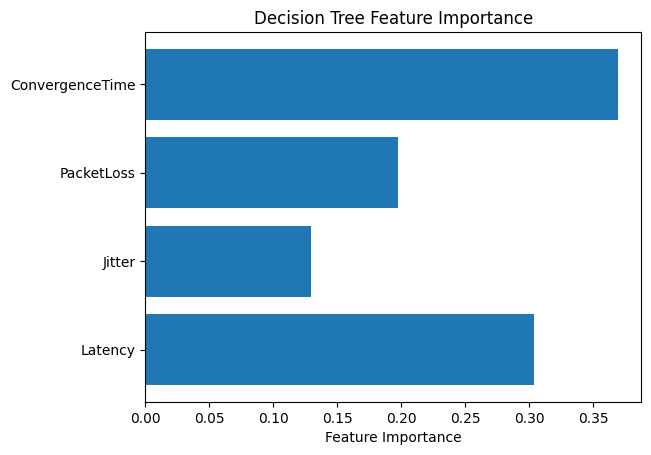

In [4]:
import matplotlib.pyplot as plt

features = X.columns
importances = model.feature_importances_
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Decision Tree Feature Importance")
plt.show()


In [9]:
import joblib
import numpy as np

# Load the trained model
model = joblib.load('routing_protocol_model.pkl')

# Define a function to make a prediction
def recommend_protocol(latency, jitter, packet_loss, convergence_time):
    input_data = np.array([[latency, jitter, packet_loss, convergence_time]])
    prediction = model.predict(input_data)
    return prediction[0]

# Example usage
predicted = recommend_protocol(30.2, 15.1, 0.35, 18.0)
print("Recommended Protocol:", predicted)


Recommended Protocol: OSPF


C:\Users\alexg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
